In [ ]:
!pip install super-gradients==3.1.0
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

In [ ]:
# Importing Required Libraries
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val
from IPython.display import clear_output
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from super_gradients.training import models

[2023-07-04 04:44:04] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-07-04 04:44:10] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-07-04 04:44:10] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-07-04 04:44:10] WARNING - export.py - Failed to import pytorch_quantization
[2023-07-04 04:44:10] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [ ]:
# Importing Dataset
CHECKPOINT_DIR = 'checkpoints2'
trainer = Trainer(experiment_name='ppe_yolonas_run2', ckpt_root_dir=CHECKPOINT_DIR)

from roboflow import Roboflow
rf = Roboflow(api_key="7kq9kKZSOqXNzpHFeB1u")
project = rf.workspace("ps1-project").project("dataset-ps1-v2-ia0e9")
dataset = project.version(1).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics<=8.0.20`, to intall it `pip install ultralytics<=8.0.20`.


Extracting Dataset Version Zip to Dataset-PS1-v2-1 in yolov8:: 100%|██████████| 718/718 [00:00<00:00, 1083.68it/s]


In [ ]:
dataset_params = {
    'data_dir':'/content/Dataset-PS1-v2-1',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['damper','insulator','plate','spacer','tower']
}

In [ ]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':12,
        'num_workers':4
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':8,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':8,
        'num_workers':2
    }
)

Caching annotations: 100%|██████████| 330/330 [00:00<00:00, 3972.85it/s]
This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
Caching annotations: 100%|██████████| 8/8 [00:00<00:00, 2905.40it/s]


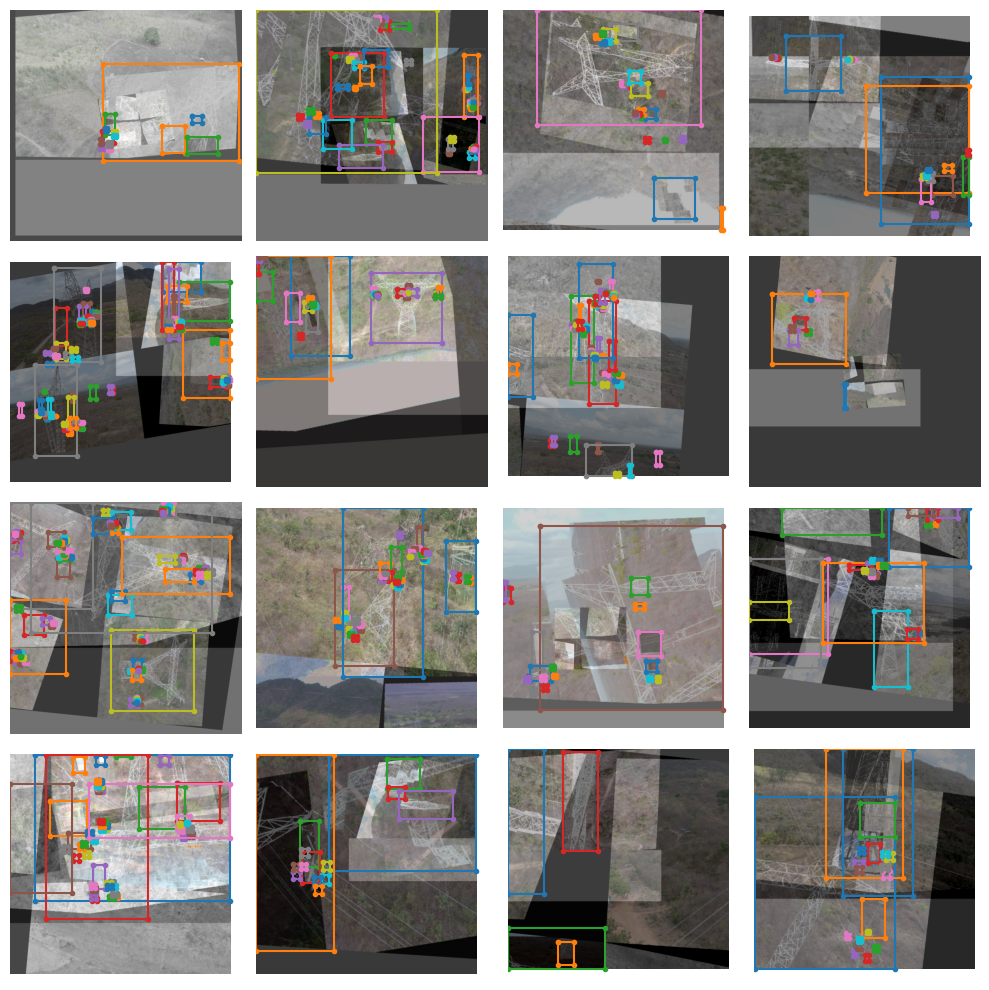

In [ ]:
train_data.dataset.plot()

In [ ]:
model = models.get('yolo_nas_l',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )

[2023-07-04 04:47:59] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


  0%|          | 0.00/256M [00:00<?, ?B/s]

Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth


In [ ]:
train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 100,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [ ]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2023-07-04 04:49:41] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-07-04 04:49:44] INFO - utils.py - NumExpr defaulting to 2 threads.


The console stream is now moved to checkpoints2/ppe_yolonas_run2/console_Jul04_04_49_45.txt


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
[2023-07-04 04:50:08] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 330        (len(train_set))
    - Batch size per GPU:           12         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             12         (num_gpus * batch_size)
    - Effective Batch size:         12         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         27         (len(train_loader))
    - Gradient updates per epoch:   27

SUMMARY OF EPOCH 100
├── Training
│   ├── Ppyoloeloss/loss = 1.7261
│   │   ├── Best until now = 1.7456 (↘ -0.0196)
│   │   └── Epoch N-1      = 1.7456 (↘ -0.0196)
│   ├── Ppyoloeloss/loss_cls = 0.7582
│   │   ├── Best until now = 0.7635 (↘ -0.0053)
│   │   └── Epoch N-1      = 0.7635 (↘ -0.0053)
│   ├── Ppyoloeloss/loss_dfl = 0.8715
│   │   ├── Best until now = 0.8898 (↘ -0.0183)
│   │   └── Epoch N-1      = 0.8902 (↘ -0.0187)
│   └── Ppyoloeloss/loss_iou = 0.2128
│       ├── Best until now = 0.2134 (↘ -0.0006)
│       └── Epoch N-1      = 0.2148 (↘ -0.002)
└── Validation
    ├── F1@0.50 = 0.0732
    │   ├── Best until now = 0.1229 (↘ -0.0496)
    │   └── Epoch N-1      = 0.0555 (↗ 0.0177)
    ├── Map@0.50 = 0.7297
    │   ├── Best until now = 0.7196 (↗ 0.0101)
    │   └── Epoch N-1      = 0.6829 (↗ 0.0469)
    ├── Ppyoloeloss/loss = 1.4735
    │   ├── Best until now = 1.528  (↘ -0.0546)
    │   └── Epoch N-1      = 1.6495 (↘ -0.176)
    ├── Ppyoloeloss/loss_cls = 0.7391
    │   ├── B

In [ ]:
best_model = models.get('yolo_nas_l',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="checkpoints2/ppe_yolonas_run2/ckpt_best.pth")

[2023-07-04 09:36:02] INFO - checkpoint_utils.py - Successfully loaded model weights from checkpoints2/ppe_yolonas_run2/ckpt_best.pth EMA checkpoint.


In [ ]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

Test: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]

{'PPYoloELoss/loss_cls': 0.86842346,
 'PPYoloELoss/loss_iou': 0.17278972,
 'PPYoloELoss/loss_dfl': 0.740191,
 'PPYoloELoss/loss': 1.6704932,
 'Precision@0.50': tensor(0.0469),
 'Recall@0.50': tensor(0.8007),
 'mAP@0.50': tensor(0.6662),
 'F1@0.50': tensor(0.0859)}

Test: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


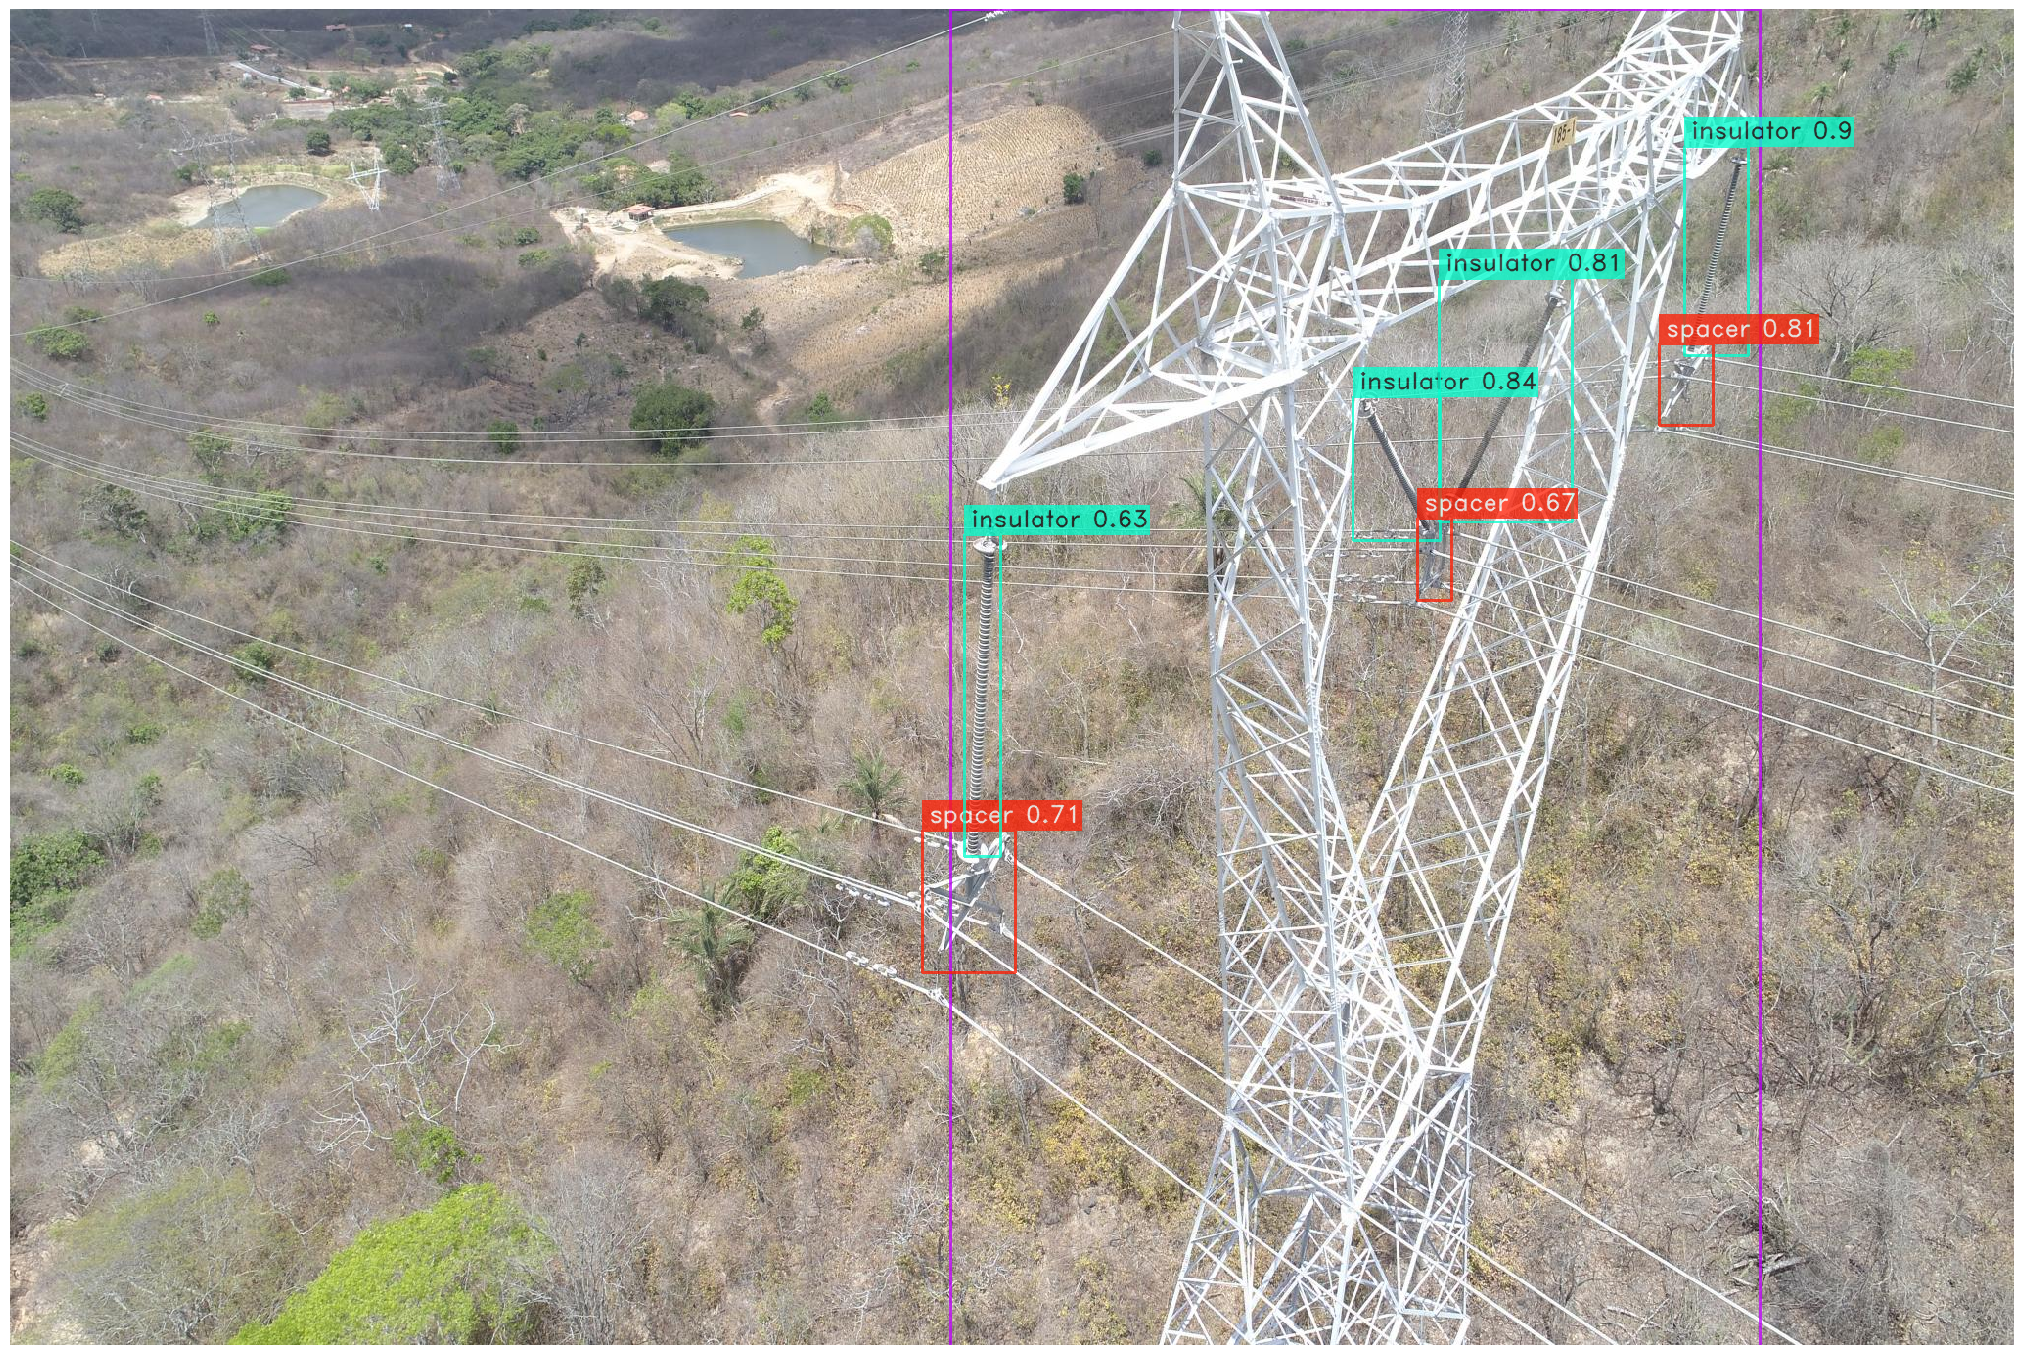

In [ ]:
img_url = '/content/Dataset-PS1-v2-1/test/images/DJI_0516_JPG.rf.a3e5604aff144c88238ea0ff68efc282.jpg'
best_model.predict(img_url).show()

In [17]:
from google.colab import drive
drive.mount('/content/drive')

In [20]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install aspose-words
!cp -r "/content/checkpoints2" "/content/drive/MyDrive"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 MB 2.4 MB/s eta 0:00:00
